In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import os 

In [78]:

folder_name = 'Fed_IT_Employment'
# get root dir which ends in folder_name
folder_dir = os.getcwd()
while os.path.basename(folder_dir) != folder_name:
    folder_dir = os.path.dirname(folder_dir)
folder_dir


'/Users/coltonlapp/Dropbox/My Mac (Coltons-MacBook-Pro.local)/Desktop/Work/USDC/publicwork/Fed_IT_Employment'

In [79]:
rdir = os.path.join( folder_dir, 'data', 'raw_data')
rdir


'/Users/coltonlapp/Dropbox/My Mac (Coltons-MacBook-Pro.local)/Desktop/Work/USDC/publicwork/Fed_IT_Employment/data/raw_data'

In [80]:
years_sep = [str(y) for y in range(1998, 2024)]
years_quart = [str(y) for y in range(2010, 2024)]


file_info = {

    'quarter_file_info': [
         { 'month':'MAR', 'years':years_quart},
         { 'month':'JUN', 'years':years_quart},
         { 'month':'SEP', 'years':years_sep},
         { 'month':'DEC', 'years':years_quart}
         ],

    'filenames' : {
        'fedscope_folder' : 'FedScope_{}{}',
        'emp_data' : 'FACTDATA_{month}{year}.TXT',
        'age_codebook' : 'DTagelvl.txt'
        }   
}



In [81]:
# Create mapping of column names to their descriptions

colname_map = {
    'AGYSUB' : 'agency',
    'LOC' : 'location',
    'AGELVL' : 'age',
    'EDLVL' : 'ed_level',
    'GSEGRD' : 'gen_sched_eq_grade',
    'LOSLVL' : 'length_of_service',
    'OCC' : 'occupation',
    'PATCO' : 'occupation_category',
    'PPGRD' : 'pay_plan_grade',
    'SALLVL' : 'salary_level',
    'STEMOCC' : 'stem_occ',
    'SUPERVIS' : 'supervisory_status',
    'TOA' : 'type_of_appointment',
    'WORKSCH' : 'work_schedule',
    'WORKSTAT' : 'work_status',
    'DATECODE' : 'date',
    'EMPLOYMENT' : 'employment',
    'SALARY' : 'avg_salary',
    'LOS' : 'avg_length_of_service'
}

# IT series
IT_series = [
    '2210' # IT Management
    #,'1515' # OR
    #,'1550' # Comp Sci
    #,'1520' # Math
    #,'1560' # Data Science
]

def map_age(df, folder):
    age_codebook = pd.read_csv(os.path.join( rdir, folder, file_info['filenames']['age_codebook']))
    
    # turn age_codebook df into a dictionary mapping  column AGELVL to column AGELVLT
    age_dict = dict(zip(age_codebook['AGELVL'], age_codebook['AGELVLT']))

    # map AGELVL to AGELVLT
    df['age'] = df['age'].map(age_dict)
    return df

In [82]:
cols_keep = ['agency', 'location', 'age', 'ed_level', 'occupation', 'occupation_category', 'pay_plan_grade', 'date']

for my_dict in file_info['quarter_file_info']:
    
    for year in my_dict['years']:
        folder = file_info['filenames']['fedscope_folder'].format(my_dict['month'].title(), year)
        fname = file_info['filenames']['emp_data'].format(month=my_dict['month'], year=year)
        print(fname)
        df = pd.read_csv(os.path.join(rdir, folder, fname))

        # rename df
        df.rename(columns=colname_map, inplace=True)
        
        # subset 
        df = df[cols_keep]

        df = map_age(df, folder)

        print(df.head())
        break

FACTDATA_MAR2010.TXT


/var/folders/np/9tdxr2056n39qzb1mpdsjrtc0000gn/T/ipykernel_15963/2258006711.py:9: DtypeWarning: Columns (1,3,6,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(rdir, folder, fname))


  agency location         age ed_level occupation  occupation_category  \
0   AA00       11  65 or more     21.0        301                    2   
1   AB00       IT       60-64      7.0       1630                    2   
2   AB00       FR       50-54      4.0       1630                    2   
3   AB00       BE       60-64      4.0       1630                    2   
4   AB00       FR       55-59     17.0        301                    2   

  pay_plan_grade    date  
0          EX-02  201003  
1          GS-12  201003  
2          GS-12  201003  
3          GS-12  201003  
4          GS-15  201003  
FACTDATA_JUN2010.TXT


/var/folders/np/9tdxr2056n39qzb1mpdsjrtc0000gn/T/ipykernel_15963/2258006711.py:9: DtypeWarning: Columns (3,6,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(rdir, folder, fname))


  agency location         age ed_level occupation  occupation_category  \
0   AA00       11  65 or more       21       0301                    2   
1   AB00       FR       50-54       10       1630                    2   
2   AB00       NL       55-59       17       1630                    2   
3   AB00       FR       55-59       10       1630                    2   
4   AB00       51       60-64       17       1035                    2   

  pay_plan_grade    date  
0          EX-02  201006  
1          GS-09  201006  
2          GS-09  201006  
3          GS-11  201006  
4          GS-15  201006  
FACTDATA_SEP1998.TXT


/var/folders/np/9tdxr2056n39qzb1mpdsjrtc0000gn/T/ipykernel_15963/2258006711.py:9: DtypeWarning: Columns (3,4,6,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(rdir, folder, fname))


  agency location    age ed_level occupation  occupation_category  \
0   AB00       IT  55-59       04       1630                    2   
1   AB00       RP  45-49       04       1630                    2   
2   AB00       BE  50-54       10       1630                    2   
3   AB00       FR  35-39       17        810                    1   
4   AB00       NL  60-64       04       1630                    2   

  pay_plan_grade    date  
0          GS-11  199809  
1          GS-08  199809  
2          GS-09  199809  
3          GS-13  199809  
4          GS-12  199809  
FACTDATA_DEC2010.TXT


/var/folders/np/9tdxr2056n39qzb1mpdsjrtc0000gn/T/ipykernel_15963/2258006711.py:9: DtypeWarning: Columns (3,6,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(rdir, folder, fname))


  agency location    age ed_level occupation  occupation_category  \
0   AA00       11  25-29       13       0950                    2   
1   AA00       11  45-49       15       0905                    1   
2   AA00       11  30-34       15       0301                    2   
3   AA00       11  25-29       15       0905                    1   
4   AA00       11  50-54       07       0301                    2   

  pay_plan_grade    date  
0          GS-07  201012  
1          ES-**  201012  
2          ES-**  201012  
3          GS-13  201012  
4          GS-12  201012  


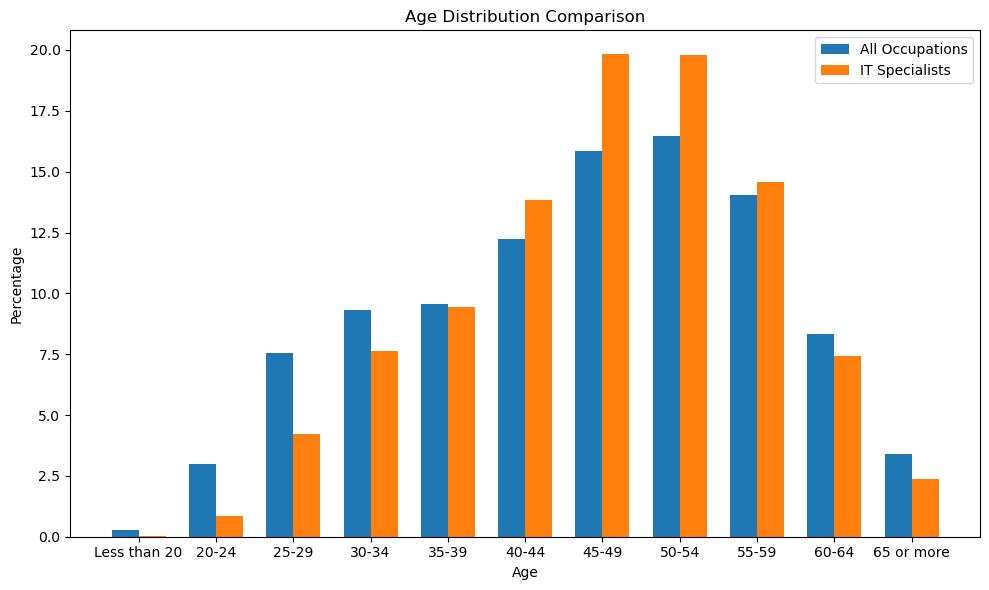

In [84]:
# cateogrical order of ages
ages = ['Less than 20', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65 or more', 'Unspecified']

# remove ages that don't occur in df
ages = [age for age in ages if age in df['age'].unique()]

# Calculate value counts as percentages
age_counts_all = df['age'].value_counts(normalize=True).loc[ages] * 100
age_counts_IT = df_IT['age'].value_counts(normalize=True).loc[ages] * 100

# Create the grouped bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Define the positions for the bars
bar_width = 0.35
index = range(len(ages))

# Plot the bars
bars_all = ax.bar(index, age_counts_all, bar_width, label='All Occupations')
bars_IT = ax.bar([i + bar_width for i in index], age_counts_IT, bar_width, label='IT Specialists')

# Add labels and title
ax.set_xlabel('Age')
ax.set_ylabel('Percentage')
ax.set_title('Age Distribution Comparison')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(ages)
ax.legend()

plt.tight_layout()
plt.show()